In [1]:
#check which version of python is being run. The follow code was made and run in python 3.11.4
from platform import python_version

print(python_version())

3.11.4


In [3]:
#dowload nltk stopwords if not done so already
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caleb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
#import used modules
import numpy as np #note: numpy 1.24.2 is used
import pandas as pd
import matplotlib.pyplot as plt
import json
import glob
import os
import re
import random
import math

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel

# spacy
import spacy
from nltk.corpus import stopwords

import pyLDAvis
import pyLDAvis.gensim

# T-5 Model
from transformers import T5Tokenizer, T5ForConditionalGeneration, pipeline

# Bertopic
from bertopic import BERTopic

In [2]:
# load data
def load_data(file):
    with open(file, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data

# write data
def write_data(file, data):
    with open(file, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)
        


# Variables

General Variables are kept here (such as which data is being used, etc.)

In [3]:
data = []

min_word_length = 3




#variable to hold data that will be processed

Setup functions that we can use later for handling our data

# Preparing the Data

Bringing up a sample json data that we have been given

In [12]:
path_to_json_files = 'Data/InternshipData-main/Internship Data ArmyAPI Pull_06222023/'
#get all JSON file names as a list
json_file_names = [filename for filename in os.listdir(path_to_json_files) if filename.endswith('.json')]

#get all data into one big list
for json_file_name in json_file_names:
    with open(os.path.join(path_to_json_files, json_file_name)) as json_file:
        json_text = json.load(json_file)
        data.append(json_text['text'])
        
print(data[0][0:200])

MIHAIL KOGALNICEANU, Romania  U.S. Army Soldiers assigned to Alpha Company, 526th Brigade Support Battalion, 2nd Brigade Combat Team, 101st Airborne Division (Air Assault), conducted a Forward Arming 


Load Test McDonald review Data

In [32]:
# load in Mcdonalds Review data from csv, latin encoding is used since non-utf-8 characters are present
data_df = pd.read_csv("Data\\McDonald_s_Reviews.csv", encoding='latin-1')
data_df = data_df.replace(r'\ï¿½', '', regex=True)
data = data_df["review"].tolist()
print(data[0])

Why does it look like someone spit on my food?
I had a normal transaction,  everyone was chill and polite, but now i dont want to eat this. Im trying not to think about what this milky white/clear substance is all over my food, i d*** sure am not coming back.


Other test data used in example video

In [33]:
test_data = load_data("C:\\Users\\caleb\\PycharmProjects\\python-selenium\\PythonPractice\\NLTK\\ushmm_dn.json")["texts"]
# print(data[0:1])
data = test_data
print(data[0][0:200])

 My name David Kochalski. I was born in a small town called , and I was born May 5, 1928.  Well, we were very hard working, six children, father and mother and we had a small mill, flour, buckwheat. W


# Data cleaning

In [77]:
# lemmatization function isolates important words using the spacy library
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

lemmatized_texts = lemmatization(data)

In [79]:
# save the lemmatized data as a JSON file to avoid long computation processs later
write_data('Data/Mili-lemm.json',lemmatized_texts)

In [37]:
# Show currently saved Data in Data Folder
[print(file) for file in os.listdir('Data') if re.search(r'.json$',file)]

Mcd-lemm.json
Mili-lemm.json


[None, None]

In [5]:
# load the lemmatized data'
lemmatized_texts = load_data('Data/Mili-lemm.json')

In [26]:
print(lemmatized_texts[0:1])

['assign conduct operation american romanian aviation asset increase knowledge future real world operation share importance training especially future use basically have fuel line element set fill helicopter fast more lethal way say conduct operation allow aviation unit refuel need stop engine enable american romanian aviation unit quickly return mission more efficient regular fueling more productive less time consume say very reliable come aviator fill take return mission as quickly possible fly mission refuel include enable soldier train refuel different type aviation asset training also help cross train other say lot different soldier here cross train operation different task maneuver training enable soldier different military occupation perform job increase knowledge fuel aviation asset future use mission important help sustain fight say 1st non - commissioned officer charge operation especially come use aviation aviation asset 101st currently deploy portion order support unrelenti

In [6]:
# use the gensim simple_preprocess function to preform a simple preprocess on data
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

# function to remove very short words from the articles, as more often than not they do not add much (NO SOURCE I MADE THIS UP)
def remove_short(texts):
    final2 = []
    for article in texts:
        final = []
        for word in article:
            if len(word) >= min_word_length:
               final.append(word)
        final2.append(final)
    return final2

# function that will generalize battalion numbers instead of getting rid of them entriely (experimental)
def generalize_numbers(texts):
    final2 = []
    for article in texts:
        final = []
        for word in article:
            word = re.sub(r'^\d+(\w+)',r'numst',word)
            final.append(word)
        final2.append(final)
    return final2

data_words = generalize_numbers([article.split() for article in lemmatized_texts])
data_words = remove_short(data_words)
data_words = gen_words([' '.join(article) for article in data_words])
print(data_words[0])

['assign', 'conduct', 'operation', 'american', 'romanian', 'aviation', 'asset', 'increase', 'knowledge', 'future', 'real', 'world', 'operation', 'share', 'importance', 'training', 'especially', 'future', 'use', 'basically', 'have', 'fuel', 'line', 'element', 'set', 'fill', 'helicopter', 'fast', 'more', 'lethal', 'way', 'say', 'conduct', 'operation', 'allow', 'aviation', 'unit', 'refuel', 'need', 'stop', 'engine', 'enable', 'american', 'romanian', 'aviation', 'unit', 'quickly', 'return', 'mission', 'more', 'efficient', 'regular', 'fueling', 'more', 'productive', 'less', 'time', 'consume', 'say', 'very', 'reliable', 'come', 'aviator', 'fill', 'take', 'return', 'mission', 'quickly', 'possible', 'fly', 'mission', 'refuel', 'include', 'enable', 'soldier', 'train', 'refuel', 'different', 'type', 'aviation', 'asset', 'training', 'also', 'help', 'cross', 'train', 'other', 'say', 'lot', 'different', 'soldier', 'here', 'cross', 'train', 'operation', 'different', 'task', 'maneuver', 'training', '

In [7]:
# Bigrams and Trigrams
bigram_phrases = gensim.models.Phrases(data_words, min_count=3, threshold=5)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=5)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return ([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print(data_bigrams_trigrams[0])

['assign', 'conduct', 'operation', 'american', 'romanian', 'aviation_asset', 'increase', 'knowledge', 'future', 'real_world', 'operation', 'share', 'importance', 'training', 'especially', 'future', 'use', 'basically', 'have', 'fuel', 'line', 'element', 'set', 'fill', 'helicopter', 'fast', 'more', 'lethal', 'way', 'say', 'conduct', 'operation', 'allow', 'aviation_unit', 'refuel', 'need', 'stop', 'engine', 'enable', 'american', 'romanian', 'aviation_unit', 'quickly', 'return', 'mission', 'more', 'efficient', 'regular', 'fueling', 'more', 'productive', 'less', 'time', 'consume', 'say', 'very', 'reliable', 'come', 'aviator', 'fill', 'take', 'return', 'mission', 'quickly', 'possible', 'fly', 'mission', 'refuel', 'include', 'enable', 'soldier_train', 'refuel', 'different', 'type', 'aviation_asset', 'training', 'also', 'help', 'cross', 'train', 'other', 'say', 'lot', 'different', 'soldier', 'here', 'cross', 'train', 'operation', 'different', 'task', 'maneuver', 'training', 'enable', 'soldier'

# Preparing the Corpora

In [8]:
#TF-IDF REMOVAL

# automatically gets rid of some of the highest occuring words from the corpus. This is done to get rid of words that aren't stop
# words, but don't nessecarily add much to acually discovering what topics are present. (For example, say the word "say")


id2word = corpora.Dictionary(data_bigrams_trigrams)
texts = data_bigrams_trigrams
corpus = [id2word.doc2bow(text) for text in texts]

tfidf = TfidfModel(corpus, id2word=id2word)

# increasing this value will increase the amount of words that are dropped because they are too frequent (according to TF-IDF)
low_value = 0.035

words = []
words_missing_in_tfidf = []


for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = []
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words + words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf score 0 will be missing
    low_value_words = [id for id in low_value_words if len(id2word[id]) <= min_word_length]
    
    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

# prints out removed words as well as their corpora id
print([(id2word[lowvalue]) for lowvalue in low_value_words])

['say', 'new', 'get', 'ask', 'too']


In [35]:
# id2word = corpora.Dictionary(data_words)

# corpus = []
# for text in data_words:
#     new = id2word.doc2bow(text)
#     corpus.append(new)
    
# print(corpus[0])


In [42]:
num_of_topics = 7
# this little line of code does all of the actual LDA modeling!
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_of_topics,
                                           random_state=49,
                                           update_every=1,
                                           chunksize=100,
                                           passes=3,
                                           alpha="auto")


# Generating Topic Names

In [43]:
topics = []
for topicNum in range(num_of_topics):
    topic_terms = lda_model.get_topic_terms(topicNum,topn=30)
    topic_term_words = [(id2word[id], percent) for id, percent in topic_terms ]
    topics.append(topic_term_words)
    

In [13]:
# create a BerTopic Model to use later to evaluate Topic names
topic_model = BERTopic()
topic_model.fit_transform(data)

([5,
  7,
  2,
  5,
  -1,
  0,
  1,
  3,
  4,
  -1,
  4,
  4,
  3,
  3,
  1,
  1,
  0,
  0,
  2,
  6,
  7,
  0,
  5,
  2,
  2,
  1,
  6,
  0,
  3,
  6,
  4,
  2,
  5,
  5,
  2,
  -1,
  -1,
  2,
  7,
  2,
  4,
  -1,
  -1,
  6,
  6,
  0,
  2,
  4,
  7,
  6,
  6,
  -1,
  0,
  3,
  1,
  0,
  1,
  2,
  0,
  -1,
  4,
  0,
  -1,
  2,
  3,
  1,
  1,
  2,
  4,
  5,
  4,
  0,
  0,
  0,
  0,
  -1,
  0,
  0,
  3,
  2,
  1,
  0,
  -1,
  3,
  5,
  1,
  1,
  1,
  1,
  1,
  7,
  1,
  4,
  -1,
  0,
  7,
  3,
  4,
  3,
  3,
  5,
  7,
  2,
  5,
  -1,
  0,
  1,
  3,
  4,
  -1,
  4,
  4,
  3,
  3,
  1,
  1,
  0,
  0,
  2,
  6,
  7,
  0,
  5,
  2,
  2,
  1,
  6,
  0,
  3,
  6,
  4,
  2,
  5,
  5,
  2,
  -1,
  -1,
  2,
  7,
  2,
  4,
  3,
  -1,
  6,
  6,
  0,
  2,
  4,
  7,
  6,
  6,
  -1,
  0,
  3,
  1,
  0,
  1,
  2,
  0,
  -1,
  4,
  0,
  -1,
  2,
  3,
  1,
  1,
  -1,
  4,
  5,
  4,
  0,
  0,
  0,
  0,
  -1,
  0,
  0,
  3,
  2,
  1,
  0,
  -1,
  3,
  5,
  1,
  1,
  1,
  1,
  1,
  7,
  1,
  4,
  -1,
  0,
 

In [14]:
# print topic groups
print(topics[0:3])

[[('numst', 0.011703893), ('say', 0.010956546), ('soldier', 0.00802974), ('unit', 0.007963312), ('support', 0.007522529), ('capability', 0.005384276), ('event', 0.004743501), ('provide', 0.0047250167), ('also', 0.0042954907), ('other', 0.0042233076), ('year', 0.004220049), ('work', 0.0040623257), ('system', 0.00367689), ('help', 0.0034787343), ('level', 0.0032466282), ('come', 0.0032226217), ('operation', 0.0032088093), ('military', 0.0032073092), ('continue', 0.0031945752), ('time', 0.0031924553), ('know', 0.0031004974), ('vehicle', 0.003063576), ('equipment', 0.0030615302), ('leader', 0.0029154576), ('more', 0.0027652094), ('use', 0.0027466002), ('take', 0.0027296615), ('include', 0.002653517), ('deploy', 0.00257637), ('part', 0.0025659155)], [('support', 0.009430401), ('numst', 0.007932322), ('provide', 0.006862245), ('operation', 0.0061270315), ('team', 0.005698706), ('soldier', 0.005633209), ('more', 0.004936436), ('unit', 0.0047258693), ('also', 0.00471232), ('exercise', 0.004592

In [44]:
# the following code will group all articles into whatever topic they are most relevant to,
# this data will be used later in order to generate article topic names 

# [(topicnum,percent),...] -> topic
# function returns the topic and percentage with the highest percent
def define_topic(docTopics):
    top = 0 
    perc = 0
    for topic,percent in docTopics:
        if percent > perc:
            top = topic
            perc = percent
    return (top,perc)
doc_topics = []
for doc in corpus:
    doc_topics.append(define_topic(lda_model.get_document_topics(doc)))
    
# print(doc_topics)
# create a dictionary with an index for each of the topics
topics_sorted = dict()

for i in range(num_of_topics):
    topics_sorted[i] = []

for i in range(len(doc_topics)):
    topics_sorted[doc_topics[i][0]].append((i,doc_topics[i][1]))
    
print(topics_sorted)
        

{0: [(2, 0.9981151), (3, 0.99625134), (5, 0.9977089), (14, 0.99388295), (24, 0.9938827), (31, 0.99619883), (35, 0.9971562), (49, 0.99701524), (50, 0.99644804), (54, 0.9692406), (63, 0.99647117), (64, 0.69525415), (80, 0.9136465), (91, 0.79357034), (97, 0.9985252)], 1: [(13, 0.9969844), (15, 0.9981522), (19, 0.82820666), (20, 0.9847058), (32, 0.9981196), (37, 0.9982784), (38, 0.99719244), (43, 0.9977328), (47, 0.79974526), (53, 0.9981196), (59, 0.9982146), (74, 0.9981459), (81, 0.9990365), (84, 0.99643695), (87, 0.8097668), (89, 0.9977333), (90, 0.99829495)], 2: [(7, 0.9980327), (21, 0.45222557), (22, 0.99887943), (23, 0.7079947), (25, 0.99576914), (26, 0.9988862), (27, 0.97361), (36, 0.9977291), (65, 0.99777526), (72, 0.9981338), (73, 0.99686575)], 3: [(0, 0.99595183), (4, 0.99695426), (11, 0.99781126), (34, 0.99755865), (42, 0.9981088), (44, 0.9971042), (45, 0.9974028), (46, 0.9973374), (57, 0.9979146), (58, 0.90232027), (66, 0.9978022), (68, 0.99847424), (78, 0.9728791), (79, 0.99575

In [24]:
# load in the T5 model that will be used to summerize and title articles
tokenizer = T5Tokenizer.from_pretrained("t5-base")
language_model = T5ForConditionalGeneration.from_pretrained("t5-base")
headline_generator = T5ForConditionalGeneration.from_pretrained("Michau/t5-base-en-generate-headline")

summarizer = pipeline("summarization", model=language_model, tokenizer=tokenizer, framework="tf")

In [29]:
def generate_topic_label(articles):
    summary_list = []
    current_token_length = 0
    max_token_length = 512
    
    for article in sample(articles, k= 5):
        summary = summarizer(article)[0]["summary_text"]
        current_token_length += len(tokenizer.encode(summary))
        if current_token_length >= max_token_length:
            break
        summary_list.append(summary)
        print(summary)

    encoding = tokenizer.encode("headline: " + " ".join(summary_list), return_tensors="pt")
    output = headline_generator.generate(encoding)
    
    return tokenizer.decode(output[0][1:-1])


In [45]:

topic_names = []
#generate a name for each topic in topics
for topic_num in range(num_of_topics):
    topic_names.append(generate_topic_label([data[i] for i,per in topics_sorted[topic_num]]))
    print(topic_names[topic_num])

print(topic_names)

KeyboardInterrupt: 

In [46]:
# bring in the T5 model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", device_map="auto")


In [32]:
#first, use a random selection of X number of keywords to generate 10 possible topics:
def gen_headlines(keywords,number_of_keywords=20,number_of_headlines=10):
    headlines = []
    for i in range(number_of_headlines):
        #randomly generate list with topics that are more relevent being more likely to apperar
        instance_keywords = random.choices([words for words,percent in keywords], weights=[percent for words,percent in keywords],k= number_of_keywords)
#         print(topics[0])
#         print(test_keywords)

        input_text = "create a topic given the following keywords: '" + ", ".join(instance_keywords) + "'"
        input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")

        outputs = model.generate(input_ids)

        # then use those topics to create one general topic
        headline = tokenizer.decode(outputs[0])
        
        # removes the html (<> padding) before and after result
        headline = re.sub(r'^<.{1,5}>|<.{0,5}$','',headline).strip()
        headlines.append(headline)
    return headlines


The following code uses something called a "cosine similarity matrix" to decide which topic best suits the keywords based on each headline's similairty to each other, more can be found here: https://medium.com/simula-consulting-deep-tech-consultancy/automatic-topic-labelling-using-nlp-1b92de15edcc


In [33]:
from bertopic import BERTopic

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def measure_similarity_of_topic(topic_labels):
  embedding = topic_model.embedding_model.embed(topic_labels)
  similarity_matrix = cosine_similarity(embedding)
  
  top_label = topic_labels[np.argmax(np.sum(similarity_matrix, axis=1))]
    
  # scoring topic
  triu_mat = np.triu(similarity_matrix, k=1)
  score = np.mean(triu_mat[np.nonzero(triu_mat)])
  
  return similarity_matrix, top_label, score


In [48]:
#generate headlines
topic_names = []
for topic in topics:
    headlines = gen_headlines(topic,number_of_keywords=10,number_of_headlines=10)
    # use the similarity to topic score
    simi, top_lab, score = measure_similarity_of_topic(headlines)
    
    topic_names.append(top_lab)
    print(top_lab)

a soldier numst deploys to a unit for the first time in his
armed forces team provides information and support to soldiers during exercise numst.
military gets people to help with mission also provides support to families and members of the military
numst need for other soldiers also need to work
soldiers maintain a well-defined perimeter around the unit to help prevent the formation of clouds and
soldier says he is continuing to help soldiers and says he is proud to be part of
data and capability to provide the skills and capabilities required for the future in the field of work


In [36]:
# displays some random articles from a given topic
# input: list of article indexes
# k: number of articles to show
def get_articles_from_topic(data,article_indexes,k=3):
    for article in sample(article_indexes,k=k):
        print(data[article])
    

In [40]:
get_articles_from_topic(data,[index for index, perc in topics_sorted[1]])

FORT SHAFTER  The 8th Human Resources Sustainment Center, 8th Theater Sustainment Commands casualty operations division conducted its first ever training exercise to assess their casualty reporting capabilities within the Indo-Pacific Command area of operations, from Jan. 17-21. The training exercise simulated wartime conditions for the 8th HRSC for Soldiers and leadership to rehearse casualty reports to brigade and division level echelons.

The 3-day exercise consisted of battle drills designed to increase the human resources Soldiers proficiency using the Defense Casualty Information Processing System, the single authorized system for casualty reporting in the Department of Defense. The unit also utilized excel spreadsheets to report casualties within a 12-hour window via email.

Sgt. Jonathan Sonnier, a human resources specialist from the casualty operations division, 8th HRSC, played a key role in helping the team achieve success by processing casualty packets in DCIPS, which helpe

[[0.9999999  0.6304208  0.4790045  0.56034696 0.40218195 0.42248312
  0.29008853 0.11728258 0.43539602 0.07472368]
 [0.6304208  1.         0.42925    0.54024744 0.5459087  0.528769
  0.4100899  0.09582747 0.56465006 0.10100758]
 [0.4790045  0.42925    1.         0.8746504  0.35037878 0.40930688
  0.44453746 0.26972157 0.5481092  0.52262723]
 [0.56034696 0.54024744 0.8746504  1.         0.42006695 0.44951218
  0.4504317  0.279424   0.6031151  0.4250691 ]
 [0.40218195 0.5459087  0.35037878 0.42006695 1.0000005  0.6205119
  0.42652884 0.00507005 0.46810007 0.09034961]
 [0.42248312 0.528769   0.40930688 0.44951218 0.6205119  1.
  0.28128314 0.10426641 0.543876   0.0846706 ]
 [0.29008853 0.4100899  0.44453746 0.4504317  0.42652884 0.28128314
  1.0000001  0.07856961 0.5217459  0.22795992]
 [0.11728258 0.09582747 0.26972157 0.279424   0.00507005 0.10426641
  0.07856961 1.         0.24709083 0.25647807]
 [0.43539602 0.56465006 0.5481092  0.6031151  0.46810007 0.543876
  0.5217459  0.24709083 1

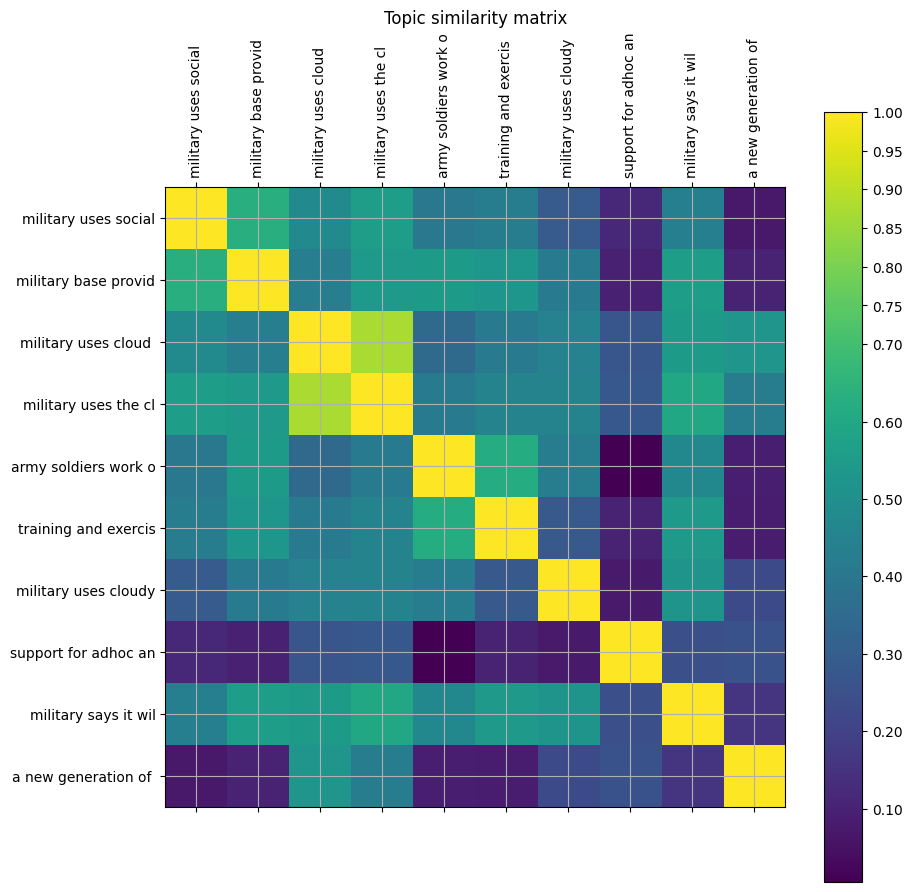

In [58]:
#give a visualization of the similarity matrix used to decide which topic is most relevant
labels = [head[:20] for head in headlines]
 
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(simi, interpolation='nearest')
ax.grid(True)
plt.title('Topic similarity matrix')
plt.xticks(range(10), labels, rotation=90);
plt.yticks(range(10), labels);
fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1])
plt.show()

In [101]:
topic_titles = []
for topic in topics:
    # Summerize the 10 headlines
    print([top for top, per in topic])
    headlines = gen_headlines(topics[0])
    # print(headlines)

    input_text = "create a topic given the following topics: '" + ", ".join(headlines) + "'"
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")

    outputs = model.generate(input_ids)

    # then use those topics to create 1 general topic
    topic_name = tokenizer.decode(outputs[0])
    topic_name = re.sub(r'^<.{1,5}>|<.{0,5}$','',topic_name).strip()
    print(topic_name)
    topic_titles.append(topic_name)
    
print(topic_titles)

['support', 'system', 'unit', 'training', 'battalion', 'team', 'maintenance', 'say', 'provide', 'cloud', 'service', 'datum', 'capability', 'social_medium', 'soldier', 'platform', 'base', 'ceremony', 'deployment', 'people', 'use', 'application', 'deploy', 'operation', 'more', 'work', 'event', 'exercise', 'power', 'train']
military base provides maintenance and support to soldiers and other people working in the military and provides a
['team', 'say', 'training', 'soldier', 'intelligence', 'work', 'fire', 'just', 'equipment', 'unit', 'need', 'exercise', 'sfab', 'analyst', 'mission', 'well', 'think', 'system', 'area', 'vehicle', 'opportunity', 'process', 'group', 'volunteer', 'other', 'also', 'cloud', 'day', 'theater', 'help']
military exercises in the cloud
['operation', 'work', 'unit', 'come', 'flight', 'information', 'capability', 'use', 'competition', 'win', 'fight', 'aircraft', 'event', 'different', 'force', 'enable', 'level', 'other', 'award', 'success', 'presentation', 'soldier', '

In [60]:
# print some of the headlines generated
[print(headline) for headline in headlines]

military said on tuesday it will deploy a contingent of soldiers to sup
 base
 military system of command and control
 cloud based training and education
cloud computing and the internet of things – a review of the role of social medi
military community provides social media and other services to soldiers and their families as part of their training
 military transport system
more than a thousand soldiers are training and deploying from a battalio
 military team training in the cloud for military operations
military personnel in training and supporting soldiers in a battalion and unit for training


[None, None, None, None, None, None, None, None, None, None]

In [59]:
print([top for top,perc in topics[0]])

['support', 'system', 'unit', 'training', 'battalion', 'team', 'maintenance', 'say', 'provide', 'cloud', 'service', 'datum', 'capability', 'social_medium', 'soldier', 'platform', 'base', 'ceremony', 'deployment', 'people', 'use', 'application', 'deploy', 'operation', 'more', 'work', 'event', 'exercise', 'power', 'train']


In [48]:

# code to remove padding from T5 results
# removes the html (<> padding) before and after result
# test_string = re.sub(r'^<.{1,5}>|<.{0,5}$','',test_string).strip()
# test_string = re.sub(r'<.{0,5}$','',test_string).strip()

test_string = "there is 1 12hour in a day34 for a time"

final = []
print(test_string.split())
for word in test_string.split():   
    word = re.sub(r'^\d+(\w+)',r'<num>\1',word)
    if word != '':
        final.append(word)
final = ' '.join(final)
print(final)

['there', 'is', '1', '12hour', 'in', 'a', 'day34', 'for', 'a', 'time']
there is 1 <num>hour in a day34 for a time


# Visualizing the Data

In [19]:
for i in range(len(topics)):
    print(topic_names[i])
#     [print(name) for name,per in topics[i]]
# print(topic_names)
# [print([name for name,per in topic]) for topic in topics]

other armed forces armed forces provide training and support to combat veterans and other armed forces
armed forces provide intelligence and support to the armed forces and their allies also provide training
military family needs to get the support of airborne units and families to ensure they execute their mission
a team of soldiers and evacuees come together for a mission to
military unit serving food in the ring also serves as a training video for soldiers in the
a soldier comes out to meet business and community leaders for a ceremony to recognize the men
other groups and individuals demonstrating the capabilities of cbm platform and other systems and services
a soldier provides training for a team of soldiers in a cloud based environment also
military says it still has armored vehicles and armored personnel carriers to fight the assault
saapm - soldiers come to find out about equipment and equipment for the soldiers
military commander uses social media to communicate with soldiers

In [93]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds="mmds", R=20, sort_topics= False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.006028 -0.100022       1        1  14.773613
1     -0.082411  0.040178       2        1  15.648982
2      0.065418  0.058082       3        1   8.891041
3      0.093298 -0.020430       4        1  19.359111
4      0.001315 -0.007535       5        1   6.663366
5     -0.069362 -0.057240       6        1  19.896713
6     -0.014285  0.086967       7        1  14.767174, topic_info=           Term       Freq      Total Category  logprob  loglift
71          say  82.000000  82.000000  Default  20.0000  20.0000
623       cloud  22.000000  22.000000  Default  19.0000  19.0000
441        work  81.000000  81.000000  Default  18.0000  18.0000
50      mission  40.000000  40.000000  Default  17.0000  17.0000
231        unit  75.000000  75.000000  Default  16.0000  16.0000
..          ...        ...        ...      ...      ...      ...
109  capability   8.490529  46.348480   Topic7  -5.7638   0.2155
441        work   9.217914  81.660946   Topic7  -5.6816  -0.2687
59        other   7.314704  28.282887   Topic7  -5.9129   0.5604
74      soldier   8.516607  98.220870   Topic7  -5.7607  -0.5324
231        unit   7.564882  75.645331   Topic7  -5.8793  -0.3898

[360 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
89        1  0.084097  ability
89        2  0.504580  ability
89        3  0.084097  ability
89        4  0.084097  ability
89        5  0.084097  ability
...     ...       ...      ...
508       3  0.078725     year
508       4  0.052484     year
508       5  0.131209     year
508       6  0.367385     year
508       7  0.131209     year

[1002 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7])